In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import numpy as np
import sys
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch.nn as nn
import re

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# importing data
train_data = pd.read_excel("Dataset/training_dataset.xlsx")
val_data = pd.read_excel("Dataset/validation_dataset.xlsx")

In [3]:
# Text cleaning
non_content = ['um','uh','mhm','mm','oh','customer','agent','says']

# Function for removing ncw and trimming beginng and end from text
def remove_ncw_trim(raw_text, additional_noncontent_words):
    
    # Replace periods with spaces (if required)
    raw_text = raw_text.replace('.', ' ')
    
    # Define English stop words (from NLTK)
    stop_words = set(stopwords.words('english'))

    # Extend stop words with your custom non-content words
    stop_words.update(additional_noncontent_words)

    # Remove sequences of 'x's or '*'s
    raw_text = re.sub(r'[x*]+', '', raw_text)

    raw_text = re.sub(r'[^A-Za-z\s]', '', raw_text)

    # Split the text into words using whitespace
    uncut_words = raw_text.split()

    # Filter out the stop words and non-content words
    filtered_words = [word for word in uncut_words if word.lower() not in stop_words]
    
    # Join words back to string
    return ' '.join(filtered_words)


train_data['cleaned_text'] = train_data['text'].apply(lambda x: remove_ncw_trim(x, non_content))
val_data['cleaned_text'] = val_data['text'].apply(lambda x: remove_ncw_trim(x, non_content))

In [4]:
print(train_data['cleaned_text'].apply(len).mean())
print(train_data['text'].apply(len).mean())
print((train_data["cleaned_text"].str.split().apply(len) > 512).mean())

1726.7383530875654
3619.6677044668468
0.13310116838198077


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=57)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])
val_data['encoded_label'] = label_encoder.transform(val_data['label'])

# Create the label mapping dictionary
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Convert the label mapping dictionary to a pandas DataFrame for easy CSV export
label_mapping_df = pd.DataFrame(list(label_mapping.items()), columns=['Label', 'Encoded'])

# Export the label mapping to a CSV file
label_mapping_df.to_csv('/mnt/data/label_mapping_v0.7.csv', index=False)


import pickle

# Save the label mapping with pickle
with open('label_mapping_v0.7.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)


# # Load the label mapping with pickle
# with open('label_mapping_v0.7.pkl', 'rb') as f:
#     loaded_label_mapping = pickle.load(f)


C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

In [7]:
train_data

,text,label,cleaned_text,encoded_label
0,agent says sir before sir. may i have your nam...,miscellaneous inquiries,sir sir may name phone number please purley nu...,25
1,agent says team best buy this is name before i...,miscellaneous inquiries,team best buy name begin may please full name ...,25
2,customer says experience there was..customer s...,bad customer service,eperience hello well problem ever happen someb...,2
3,customer says i dont know. now its up and runn...,miscellaneous inquiries,dont know running think got rid emails maybe s...,25
4,agent says mhm.agent says yeah..customer says ...,miscellaneous inquiries,yeah hello hello yeah come hello hello thanks ...,25
...,...,...,...,...
379323,agent says thank you for calling best buy my n...,rewards or discounts,thank calling best buy name date ask full name...,42
379324,agent says moment your phone number please.cus...,product details inquiry,moment phone number please hi name trisha name...,33
379325,agent says calling me back. this is name i hav...,schedule repair,calling back name name phone number please nam...,46
379326,agent says hi thanks for calling best buy this...,troubleshooting,hi thanks calling best buy name get started fu...,53


In [8]:
# Tokenize the training data
train_texts = train_data['cleaned_text'].tolist()
train_labels = train_data['encoded_label'].tolist()

# Tokenize the validation data
val_texts = val_data['cleaned_text'].tolist()
val_labels = val_data['encoded_label'].tolist()

In [9]:
# TOKENIZER - TAKES TIME

val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
print("val encoding done")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
print("train encoding done")

val encoding done
train encoding done


In [10]:
train_encodings["input_ids"].shape

torch.Size([379328, 512])

In [11]:
print("Number of Unique Words:", train_encodings["input_ids"].max())

Number of Unique Words: tensor(29610)


In [12]:
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [13]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

In [14]:
print(train_dataset)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [16]:
train_loader

In [17]:
import os

# Checkpointing setup
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Default values for checkpoint variables
best_val_loss = float('inf')
start_epoch = 0


# # # Path to the checkpoint file you want to resume from
# # latest_checkpoint_path = 'checkpoints/' 

# # Load the checkpoint if it exists
# if os.path.exists(latest_checkpoint_path):
#     checkpoint = torch.load(latest_checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch']
#     best_val_loss = checkpoint['loss']
#     print(f"Resumed training from epoch {start_epoch} with loss {best_val_loss}")

In [18]:
start_epoch=0
epochs = 3
lr = 5e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Training loop WITH LOGITS
logits = []
for epoch in range(start_epoch, epochs):
    i = 0
    model.train()

    # Initialize training loss for the epoch
    total_train_loss = 0
    
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        total_train_loss += loss.item()
        
        sys.stdout.write("\rProcessing: [{:<50}] {:.2f}%".format('=' * int((i + 1) / len(train_loader) * 50), (i + 1) / len(train_loader) * 100))
        sys.stdout.flush()
        
        i += 1

    # Compute the average training loss over the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    
    print(f'\nTraining Done: Epoch {epoch + 1}/{epochs}')
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            
            logits.extend(outputs.logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
            }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    micro_f1 = f1_score(all_labels, all_predictions, average='micro')
    weighted_f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    # Display the training and validation loss
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Micro F1 Score: {micro_f1:.4f}, Weighted F1 Score: {weighted_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Save the trained model if needed
torch.save(model.state_dict(), 'distilbert_model_v0.7.pth')


Processing: [==================================================] 100.00%
Training Done: Epoch 1/3
Checkpoint saved at checkpoints\checkpoint_epoch_1.pth
Epoch 1/3, Training Loss: 1.1887, Validation Loss: 1.0049, Micro F1 Score: 0.6620, Weighted F1 Score: 0.6550, Precision: 0.6627, Recall: 0.6620
Processing: [==================================================] 100.00%
Training Done: Epoch 2/3
Checkpoint saved at checkpoints\checkpoint_epoch_2.pth
Epoch 2/3, Training Loss: 0.9190, Validation Loss: 0.9500, Micro F1 Score: 0.6744, Weighted F1 Score: 0.6689, Precision: 0.6798, Recall: 0.6744
Processing: [==================================================] 100.00%
Training Done: Epoch 3/3
Epoch 3/3, Training Loss: 0.7934, Validation Loss: 0.9642, Micro F1 Score: 0.6746, Weighted F1 Score: 0.6701, Precision: 0.6761, Recall: 0.6746


Precision: 0.6761, Recall: 0.6746


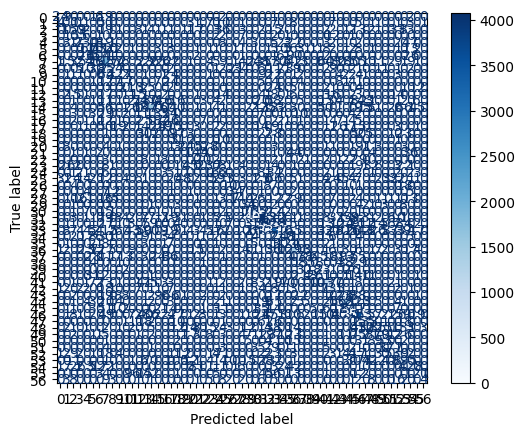

In [20]:
# evaluation metrics
import matplotlib.pyplot as plt

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [21]:
# At the end of your existing code
print(f'Final Avg Training Loss: {avg_train_loss:.4f}')
print(f'Final Avg Validation Loss: {avg_val_loss:.4f}')
print(f'Final Micro F1 Score: {micro_f1:.4f}')
print(f'Final Weighted F1 Score: {weighted_f1:.4f}')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')

Final Avg Training Loss: 0.7934
Final Avg Validation Loss: 0.9642
Final Micro F1 Score: 0.6746
Final Weighted F1 Score: 0.6701
Final Precision: 0.6761
Final Recall: 0.6746


In [22]:
# import pandas as pd
# import numpy as np

# # Assuming `logits` is a list of arrays as you provided
# all_logits = np.concatenate(logits, axis=0)

# # Number of data points in the validation dataset
# num_val_data_points = len(val_data)

# # Since each epoch's logits are equal to the size of the validation dataset
# # Extract logits from the second epoch
# start_index = num_val_data_points
# end_index = start_index + num_val_data_points
# epoch_2_logits = all_logits[start_index:end_index]

# # Convert the logits for epoch 2 into a DataFrame
# logits_df = pd.DataFrame(epoch_2_logits)

# # Ensure the validation dataset is in the same order as the logits
# combined_df = pd.concat([val_data.reset_index(drop=True), logits_df.reset_index(drop=True)], axis=1)


# combined_df.head(10)

In [23]:
# Export to CSV
combined_df.to_csv("validation_data_with_epoch_2_logits.csv", index=False)

NameError: name 'combined_df' is not defined